In [1]:
import modin.pandas as mipd
import os
import time
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [2]:
time_resolution = 2

## Technique Network

+ View the Dataset here, read from the saved csv
++ Route('/mnt/data0/lkyin/network_data/emails/')

In [3]:
#c_path = '/mnt/data0/lkyin/monthly_data/commits/'
c_path = './monthly_data/commits/'
projects = os.listdir(c_path)

In [4]:
len(projects)

4975

In [5]:
proj_names = []
for project in tqdm(projects):
    project_name, period = project.replace('.csv', '').split('__')
    proj_names.append(project_name)

pd_proj_names = pd.Series(proj_names)
pd_proj_names.describe()

100%|██████████| 4975/4975 [00:00<00:00, 757493.10it/s]


count        4975
unique        263
top       jspwiki
freq           60
dtype: object

In [6]:
df_commits = pd.read_csv(c_path+projects[0])
df_commits.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'sender_email', 'author_name', 'author_email',
       'file_name', 'loc', 'ref_or_sha', 'subject', 'commit_type',
       'author_full_name', 'is_bot', 'is_coding', 'dealised_author_full_name'],
      dtype='object')

In [7]:
df_commits.describe()

,month,loc,ref_or_sha
count,141.0,141.000000,1.410000e+02
mean,3.0,17.801418,1.653554e+06
std,0.0,64.265212,1.873481e+03
min,3.0,0.000000,1.651679e+06
25%,3.0,0.000000,1.651876e+06
50%,3.0,2.000000,1.651927e+06
75%,3.0,6.000000,1.655592e+06
max,3.0,666.000000,1.656140e+06


In [8]:
df_commits.head(5)

,project_name,list_name,date,month,message_id,sender_name,sender_email,author_name,author_email,file_name,loc,ref_or_sha,subject,commit_type,author_full_name,is_bot,is_coding,dealised_author_full_name
0,taverna,commits,2015-01-14 14:24:27,3,<20150114142428.514D1AC003F@hades.apache.org>,brenninc,brenninc@apache.org,brenninc,None,incubator/taverna/site/trunk/templates/skeleto...,9.0,1651679,svn commit: r1651679 - /incubator/taverna/site...,svn,christian y. brenninkmeijer,False,True,Christian Brenninkmeijer
1,taverna,commits,2015-01-14 14:58:44,3,<20150114145844.B6FE7AC0163@hades.apache.org>,stain,stain@apache.org,stain,None,incubator/taverna/site/trunk/content/ns/index....,0.0,1651691,svn commit: r1651691 [1/4] - in /incubator/tav...,svn,stian soiland-reyes,False,True,Stian Soiland-reyes
2,taverna,commits,2015-01-14 15:21:10,3,<20150114152110.7BA0AAC0163@hades.apache.org>,stain,stain@apache.org,stain,None,incubator/taverna/site/trunk/content/ns/index....,17.0,1651701,svn commit: r1651701 - /incubator/taverna/site...,svn,stian soiland-reyes,False,True,Stian Soiland-reyes
3,taverna,commits,2015-01-14 15:42:26,3,<20150114154226.5DF98AC003F@hades.apache.org>,stain,stain@apache.org,stain,None,incubator/taverna/site/trunk/content/updates/d...,0.0,1651708,svn commit: r1651708 - in /incubator/taverna/s...,svn,stian soiland-reyes,False,True,Stian Soiland-reyes
4,taverna,commits,2015-01-14 15:42:26,3,<20150114154226.5DF98AC003F@hades.apache.org>,stain,stain@apache.org,stain,None,incubator/taverna/site/trunk/content/updates/i...,0.0,1651708,svn commit: r1651708 - in /incubator/taverna/s...,svn,stian soiland-reyes,False,True,Stian Soiland-reyes


## ASF Techinical Network Construction from Likang
+ Using NetworkX for analysis
    + https://www.osgeo.cn/networkx/tutorial.html#attributes

    + Use Pandas with NetworkX https://www.jianshu.com/p/11456474d8a5

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null (SVN has 'noauthor')
    + For each row:
        + Check if file name exist as node
        + Add file as Node
        + Edges saved in technical_net as a set
        + for each commit on each file, weight +1
    + Use technical_net to construct graph
        + Network attributes from the dictionary: https://www.osgeo.cn/networkx/tutorial.html#attributes

In [9]:
#c_path = '/mnt/data0/lkyin/monthly_data/commits/'
c_path = './monthly_data/commits/'
projects = os.listdir(c_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
to_path = './network_data'+str(time_resolution)+'/commits/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
gx_technets = []
for project in tqdm(projects):
    technical_net = {}
    project_name, period = project.replace('.csv', '').split('__')
    if int(period)%time_resolution!=0 :
        continue
    fnames = [project_name+'__'+str(int(period)+i)+'.csv' for i in range(time_resolution) ]
    for fname in fnames:
        if not os.path.exists(c_path+fname):
            continue
        df = pd.read_csv(c_path+fname)
        df.query('is_bot == False and is_coding == True', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        for index, row in df.iterrows():
            file_path = row['file_name']
            # file extension = '.' + file_path.split('/')[-1].split('.')[-1].split(' ')[0]
            file_name = file_path.split('/')[-1]
            author_name = row['dealised_author_full_name']
            if file_name not in technical_net:
                technical_net[file_name] = {}
            if author_name not in technical_net[file_name]:
                technical_net[file_name][author_name] = {}
                technical_net[file_name][author_name]['weight'] = 0
            technical_net[file_name][author_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(technical_net)
    # add disconnected nodes
    g.add_nodes_from(technical_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_technets.append(g)

100%|██████████| 4975/4975 [05:09<00:00, 16.08it/s] 


In [10]:
technical_net


{'fckconfig.js': {'Glen Mazza': {'weight': 1}},
 'prettify.js': {'Glen Mazza': {'weight': 1}},
 'Release.java': {'Glen Mazza': {'weight': 11}, 'Harry Metske': {'weight': 1}},
 'CustomXMLOutputProcessor.java': {'Glen Mazza': {'weight': 2}},
 'SecurityVerifier.java': {'Glen Mazza': {'weight': 3}},
 'WebContainerAuthorizer.java': {'Glen Mazza': {'weight': 1}},
 'DefaultFilterManager.java': {'Glen Mazza': {'weight': 2}},
 'HtmlStringToWikiTranslator.java': {'Glen Mazza': {'weight': 1}},
 'XHtmlElementToWikiTranslator.java': {'Glen Mazza': {'weight': 1}},
 'WikiModuleInfo.java': {'Glen Mazza': {'weight': 1}},
 'JSPWikiMarkupParser.java': {'Glen Mazza': {'weight': 3}},
 'LinkParser.java': {'Glen Mazza': {'weight': 2}},
 'PluginContent.java': {'Glen Mazza': {'weight': 1}},
 'VariableContent.java': {'Glen Mazza': {'weight': 1}},
 'WikiDocument.java': {'Glen Mazza': {'weight': 1}},
 'DefaultPluginManager.java': {'Glen Mazza': {'weight': 1}},
 'CleanTextRenderer.java': {'Glen Mazza': {'weight': 

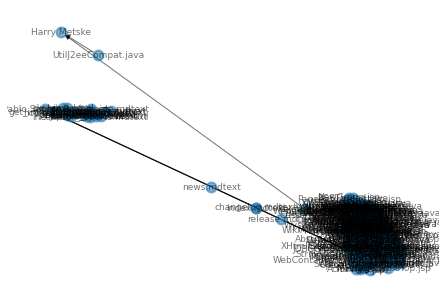

In [11]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)

## ASF Social Networks Construction From Likang

+ How this network is constructed (Data already saved as commits for each project each month):
    + Tow features: "is_bot" as False and "is_coding" as True
    + Author is not null
    + For each email:
        + Check if this email have previous references, if not, quit and go next
        + Add previous authors as Nodes
        + Edges saved in social_net as a node
        + for each email sent to previous edges on each file, mutually (sender to previous & previous to sender) weight +1

In [12]:
#e_path = '/mnt/data0/lkyin/monthly_data/emails/'
e_path = './monthly_data/emails/'
projects = os.listdir(e_path)

In [13]:
for project in tqdm(projects[:1]):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    df = pd.read_csv(e_path+project)
    df.query('is_bot == False', inplace=True)
    df = df[df['dealised_author_full_name'].notna()]

100%|██████████| 1/1 [00:00<00:00, 110.66it/s]


In [14]:
df.columns

Index(['project_name', 'list_name', 'date', 'month', 'message_id',
       'sender_name', 'references', 'sender_email', 'in_reply_to', 'cc_list',
       'receiver_email', 'subject', 'body', 'from_commit', 'author_full_name',
       'is_bot', 'dealised_author_full_name'],
      dtype='object')

In [15]:
df.describe()

,month
count,62.0
mean,2.0
std,0.0
min,2.0
25%,2.0
50%,2.0
75%,2.0
max,2.0


In [16]:
df.head(5)

,project_name,list_name,date,month,message_id,sender_name,references,sender_email,in_reply_to,cc_list,receiver_email,subject,body,from_commit,author_full_name,is_bot,dealised_author_full_name
0,taverna,dev,2014-12-01 01:11:07,2.0,<CAPRnXtmtwnMV_x38qy8MOtCCCgW2dLBZ05yPxQUty7Hk...,Stian Soiland-Reyes,<CACnO1SHVo5aBWxe1DdXWkgKcFE2c1K0_Lv=UtGv=c9+t...,soiland-reyes@cs.manchester.ac.uk,<CACnO1SHnGxKcWNn380k2pCpn5zq=nBQPUsyYHVmk5Umx...,None,Nebojsa Tijanic <nebojsa.tijanic@sbgenomics.co...,Re: Workflow model,(dev@taverna - you might see that I occasional...,False,stian soilandreyes,False,Stian Soiland-reyes
1,taverna,dev,2014-12-01 09:38:25,2.0,<547C3711.5030702@apache.org>,Andy Seaborne,<5471BEAB.2070406@apache.org> <5473422B.300080...,andy@apache.org,<CAPRnXtkA2FhS_tuZA61P+kKxSE_paS9EkBvpeEpkwZ3Q...,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,Report signed off by me.\nIf the other mentors...,False,andy seaborne,False,Andy Seaborne
2,taverna,dev,2014-12-01 09:09:28,2.0,<547C7698.2040606@iu.edu>,Marlon Pierce,<5471BEAB.2070406@apache.org> <5473422B.300080...,marpierc@iu.edu,<547C3711.5030702@apache.org>,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,I'll sign off but I don't have edit privileges...,False,marlon pierce,False,Marlon Pierce
3,taverna,dev,2014-12-01 14:14:46,2.0,<BB3E9C4E-5430-4F8A-AD60-090776A41A00@16degree...,Gavin McDonald,<5471BEAB.2070406@apache.org> <5473422B.300080...,gavin@16degrees.com.au,<547C7698.2040606@iu.edu>,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,"\nOn 01/12/2014, at 2:09 PM, Marlon Pierce <ma...",False,gavin mcdonald,False,Gavin Mcdonald
4,taverna,dev,2014-12-01 09:16:36,2.0,<547C7844.3020000@iu.edu>,Marlon Pierce,<5471BEAB.2070406@apache.org> <5473422B.300080...,marpierc@iu.edu,<BB3E9C4E-5430-4F8A-AD60-090776A41A00@16degree...,None,dev@taverna.incubator.apache.org,Re: Incubator report : Dec 2014,"I have. I'm MarlonPierce.\n\nOn 12/1/14, 9:14 ...",False,marlon pierce,False,Marlon Pierce


In [17]:
to_path = './network_data'+str(time_resolution)+'/emails/'
if not os.path.exists(to_path):
    os.makedirs(to_path)
#e_path = '/mnt/data0/lkyin/monthly_data/emails/'
e_path = './monthly_data/emails/'
projects = os.listdir(e_path)
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
gx_socialnets = []
for project in tqdm(projects):

    social_net = {}
    emailID_to_author = {}
    project_name, period = project.replace('.csv', '').split('__')
    if int(period)%time_resolution!=0 :
        continue
    fnames = [project_name+'__'+str(int(period)+i)+'.csv' for i in range(time_resolution) ]
    for fname in fnames:
        if not os.path.exists(e_path+fname):
            continue
        df = pd.read_csv(e_path+fname)
        df.query('is_bot == False', inplace=True)
        df = df[df['dealised_author_full_name'].notna()]
        
        for index, row in df.iterrows():
            message_id = row['message_id'].strip()
            # print(row['dealised_author_full_name'])
            sender_name = row['dealised_author_full_name']
            emailID_to_author[message_id] = sender_name

        # raise KeyError
        for index, row in df.iterrows():
            message_id = row['message_id']
            references = row['references']
            sender_name = row['dealised_author_full_name']

            # ignores if this email does not to previous emails
            if pd.isna(references) or references == 'None':
                continue

            references = [r.strip() for r in references.replace('\n', ' ').replace('\t', ' ').split(' ') if r.strip()]

            # deal with the issue that a line breaker exists in message_id:
            # e.g., <4\n829AB62.6000302@apache.org>
            new_refs = set()
            for i in range(len(references)-1):
                if '<' in references[i] and '>' not in references[i] and '<' not in references[i+1] and '>' in references[i+1]:
                    new_refs.add(references[i] + references[i+1])
            for r in references:
                if '<' in r and '>' in r:
                    new_refs.add(r)

            references = new_refs
            for reference_id in references:
                if reference_id not in emailID_to_author:
                    continue
                prev_author = emailID_to_author[reference_id]
                # if it's the same person, continue
                if prev_author == sender_name:
                    continue
                if sender_name not in social_net:
                    social_net[sender_name] = {}
                if prev_author not in social_net:
                    social_net[prev_author] = {}

                # if node B replies node A, it means B sends signal to A
                if prev_author not in social_net[sender_name]:
                    social_net[sender_name][prev_author] = {}
                    social_net[sender_name][prev_author]['weight'] = 0
                social_net[sender_name][prev_author]['weight'] += 1

                # if node B replies node A, it means A also sent signal to B
                if sender_name not in social_net[prev_author]:
                    social_net[prev_author][sender_name] = {}
                    social_net[prev_author][sender_name]['weight'] = 0
                social_net[prev_author][sender_name]['weight'] += 1

    #save as directed graph
    g = nx.DiGraph(social_net)
    # add disconnected nodes
    g.add_nodes_from(social_net.keys())
    nx.write_edgelist(g, to_path + '{}__{}.edgelist'.format(project_name, str(period)), delimiter='##', data=["weight"])
    gx_socialnets.append(g)

100%|██████████| 6357/6357 [02:46<00:00, 38.13it/s] 


In [18]:
projects.sort(key= lambda x:int(x.split('__')[1].split('.')[0]))
projects

['datasketches__1.csv',
 'twill__1.csv',
 'samoa__1.csv',
 'horn__1.csv',
 'npanday__1.csv',
 's4__1.csv',
 'kitty__1.csv',
 'oodt__1.csv',
 'groovy__1.csv',
 'phoenix__1.csv',
 'nmaven__1.csv',
 'stanbol__1.csv',
 'gobblin__1.csv',
 'sanselan__1.csv',
 'stratos__1.csv',
 'jspwiki__1.csv',
 'ariatosca__1.csv',
 'impala__1.csv',
 'taverna__1.csv',
 'libcloud__1.csv',
 'openaz__1.csv',
 'provisionr__1.csv',
 'jackrabbit__1.csv',
 'openwhisk__1.csv',
 'ant__1.csv',
 'hdt__1.csv',
 'couchdb__1.csv',
 'esme__1.csv',
 'kalumet__1.csv',
 'vxquery__1.csv',
 'gora__1.csv',
 'heraldry__1.csv',
 'directmemory__1.csv',
 'usergrid__1.csv',
 'commonsrdf__1.csv',
 'bigtop__1.csv',
 'flume__1.csv',
 'joshua__1.csv',
 'mrql__1.csv',
 'hawq__1.csv',
 'unomi__1.csv',
 'hise__1.csv',
 'servicecomb__1.csv',
 'roller__1.csv',
 'superset__1.csv',
 'alois__1.csv',
 'weex__1.csv',
 'wicket__1.csv',
 'jclouds__1.csv',
 'sqoop__1.csv',
 'geode__1.csv',
 'xmlbeans__1.csv',
 'nutch__1.csv',
 'dubbo__1.csv',
 'quic

In [19]:
social_net

{'Svante Schubert': {'Andrew Willerding': {'weight': 16},
  'David Fisher': {'weight': 4},
  'Yegor Kozlov': {'weight': 1},
  'Michael Stahl': {'weight': 1}},
 'Andrew Willerding': {'Svante Schubert': {'weight': 16}},
 'Tom Barber': {'David Fisher': {'weight': 2}},
 'David Fisher': {'Tom Barber': {'weight': 2},
  'Nick Burch': {'weight': 1},
  'Danese Cooper': {'weight': 1},
  'Yegor Kozlov': {'weight': 2},
  'Svante Schubert': {'weight': 4},
  'Michael Stahl': {'weight': 1}},
 'Nick Burch': {'David Fisher': {'weight': 1}},
 'Danese Cooper': {'David Fisher': {'weight': 1}},
 'Yegor Kozlov': {'David Fisher': {'weight': 2},
  'Svante Schubert': {'weight': 1}},
 'Michael Stahl': {'Svante Schubert': {'weight': 1},
  'David Fisher': {'weight': 1}}}

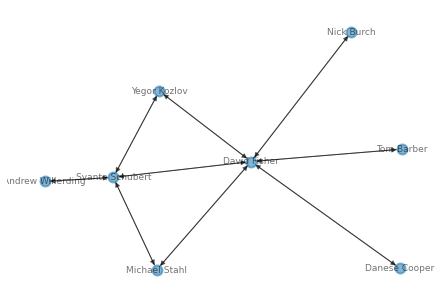

In [20]:
#nx.draw(g, with_labels=True, font_weight='bold')
nx.draw(g,
    with_labels=True,
    #pos = nx.sprint_layout(g),
    #node_color=color_list,
    edge_color='k',
    node_size=100,
    node_shape='o',
    linewidths=2,
    width=1.0,
    alpha=0.55,
    style='solid',
    font_size=9,
    font_color='k'
)